In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('fashion_mnist1.csv')

In [ ]:
# Check dimensionality
n_samples, n_features = df.shape
print(f"Number of samples (rows): {n_samples}")
print(f"Number of features (columns): {n_features}")

if n_features > n_samples:
    print("The dataset is highly dimensional (more features than samples).")
else:
    print("The dataset is not highly dimensional (more samples than features).")

Number of samples (rows): 10000
Number of features (columns): 785
The dataset is not highly dimensional (more samples than features).


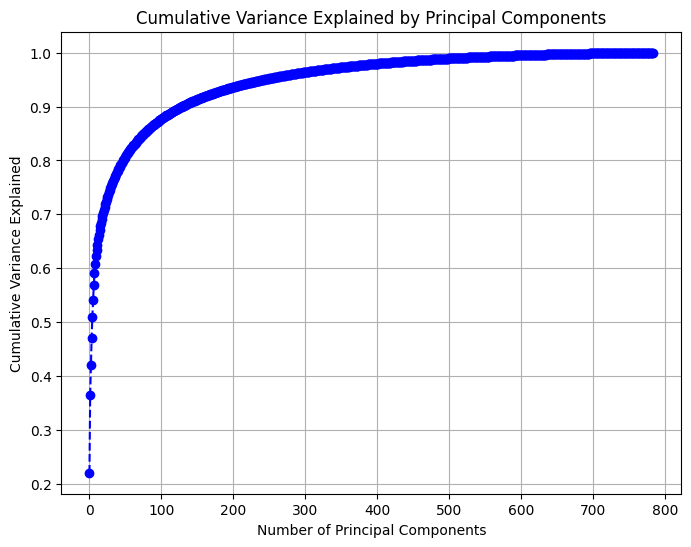

Number of components that explain 95% of the variance: 243


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

X = df.iloc[:, 1:].values  # Features (excluding the label in the first column)

# Normalizing the data (mean = 0, standard deviation = 1)
mean = np.mean(X, axis=0)
std_dev = np.std(X, axis=0)
X_normalized = (X - mean) / std_dev

# Performing Singular Value Decomposition (SVD) on normalized data
U, S, VT = np.linalg.svd(X_normalized)

#Calculating explained variance
explained_variance = (S ** 2) / np.sum(S ** 2)

# Calculating cumulative variance explained
cumulative_variance = np.cumsum(explained_variance)

#Visualizing cumulative variance explained
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Variance Explained by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()

#Checking how many components explain 95% of the variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components that explain 95% of the variance: {n_components_95}")


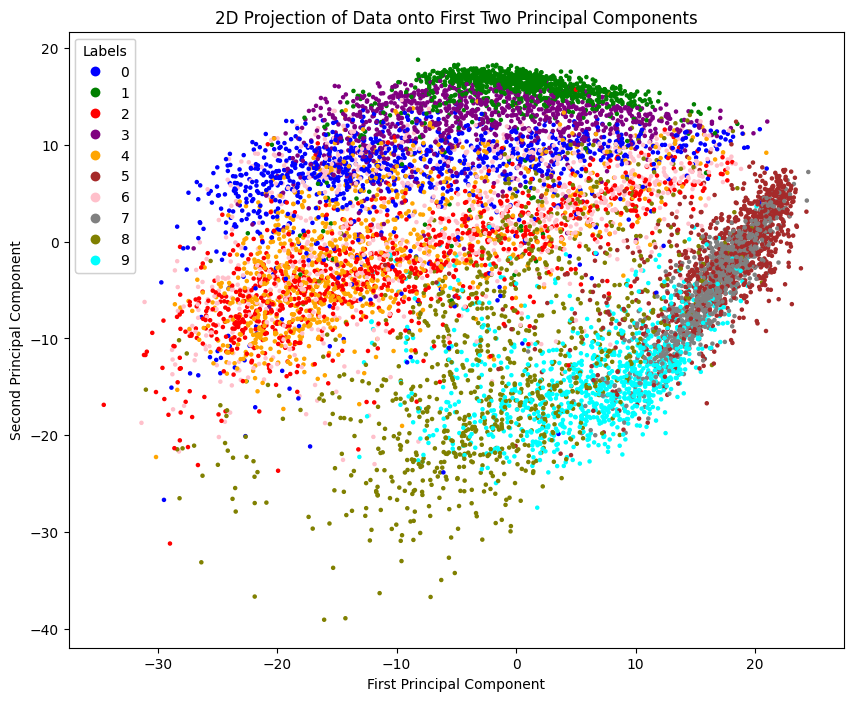

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# (separating features and labels)
X = df.iloc[:, 1:].values  # Features (excluding the label in the first column)
y = df.iloc[:, 0].values   # Labels (first column)

#  Normalizing the data (Z-score normalization)
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_std[X_std == 0] = 1  # Prevent division by zero for constant features
X_normalized = (X - X_mean) / X_std

# Computing the Covariance Matrix
cov_matrix = np.cov(X_normalized, rowvar=False)

# Performing Singular Value Decomposition (SVD)
U, S, VT = np.linalg.svd(cov_matrix)

# Extracting the first two principal components (from VT)
PC1 = VT[0, :]  # First Principal Component
PC2 = VT[1, :]  # Second Principal Component

X_pca = np.dot(X_normalized, VT.T[:, :2])
X_pca[:, 1] = -X_pca[:, 1]

plt.figure(figsize=(10, 8))
colors = ListedColormap(['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan'])
# Scatter plot with color based on the label
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=colors, s=5)
plt.title('2D Projection of Data onto First Two Principal Components')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Creating a legend for 10 unique labels
legend1 = plt.legend(*scatter.legend_elements(num=10), title="Labels")
plt.gca().add_artist(legend1)
plt.show()

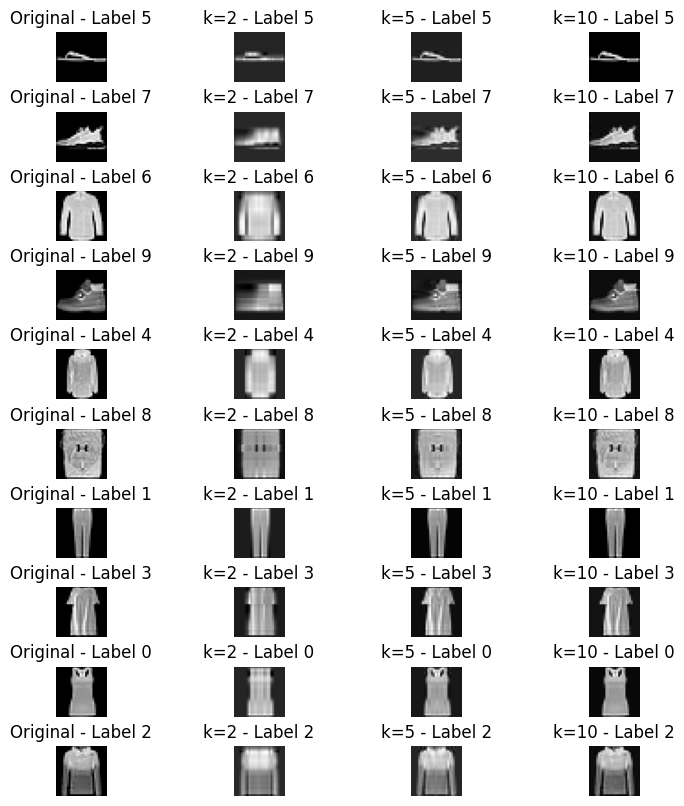

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import svd

# (10 unique labels)
unique_labels = df['label'].unique()[:10]
selected_images = []
for label in unique_labels:
    img = df[df['label'] == label].iloc[0, 1:].values.reshape(28, 28)
    selected_images.append((img, label))

# compressing an image using SVD with k components
def compress_image(img, k):
    U, S, Vt = svd(img, full_matrices=False)
    S = np.diag(S[:k])
    compressed_img = np.dot(U[:, :k], np.dot(S, Vt[:k, :]))
    return compressed_img

fig, axes = plt.subplots(nrows=len(selected_images), ncols=4, figsize=(8, 8))
for i, (img, label) in enumerate(selected_images):
    # Original image
    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 0].set_title(f"Original - Label {label}")
    axes[i, 0].axis('off')

    # Compressed with k=2
    compressed_k2 = compress_image(img, 2)
    axes[i, 1].imshow(compressed_k2, cmap='gray')
    axes[i, 1].set_title(f"k=2 - Label {label}")
    axes[i, 1].axis('off')

    # Compressed with k=5
    compressed_k5 = compress_image(img, 5)
    axes[i, 2].imshow(compressed_k5, cmap='gray')
    axes[i, 2].set_title(f"k=5 - Label {label}")
    axes[i, 2].axis('off')

    # Compressed with k=10
    compressed_k10 = compress_image(img, 10)
    axes[i, 3].imshow(compressed_k10, cmap='gray')
    axes[i, 3].set_title(f"k=10 - Label {label}")
    axes[i, 3].axis('off')

plt.tight_layout(pad=0.5)
plt.show()

t-SNE

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

# Loading the Fashion MNIST dataset
data = pd.read_csv('fashion_mnist1.csv')
X = data.iloc[:, 1:].values  # Pixel values (image features)
y = data.iloc[:, 0].values   # Image labels

# Setting the device for GPU acceleration (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.long).to(device)

# Normalizing pixel values to [0, 1] range
X /= 255.0

def _hbeta_search(Di, beta):
    probs = torch.exp(-Di * beta)
    sum_probs = torch.sum(probs)
    probs /= sum_probs
    entropy = torch.log(sum_probs) + beta * torch.sum(Di * probs)
    return entropy, probs

# Computing P matrix
def calculate_matrix_p(X, perplexity=30.0, tolerance=1e-5):
    n_samples = X.shape[0]
    log_perp = torch.log(torch.tensor(perplexity))
    squared_distances = torch.cdist(X, X, p=2).pow(2)  # pairwise squared distances
    P = torch.zeros((n_samples, n_samples), device=device)

    for i in tqdm(range(n_samples), desc="P matrix computation"):
        beta = torch.tensor(1.0, device=device)
        beta_min, beta_max = None, None
        D_i = squared_distances[i, torch.arange(n_samples) != i]

        H, probs = _hbeta_search(D_i, beta)
        diff = H - log_perp

        while torch.abs(diff) > tolerance:
            if diff > 0:
                beta_min = beta.clone()
                beta = beta * 2 if beta_max is None else (beta + beta_max) / 2
            else:
                beta_max = beta.clone()
                beta = beta / 2 if beta_min is None else (beta + beta_min) / 2

            H, probs = _hbeta_search(D_i, beta)
            diff = H - log_perp

        P[i, torch.arange(n_samples) != i] = probs

    P = (P + P.T) / (2 * n_samples)
    return torch.clamp(P, min=1e-12)

# Computing Q matrix (low-dimensional similarities)
def calculate_matrix_q(Y):
    pairwise_sq_distances = 1 / (1 + torch.cdist(Y, Y, p=2).pow(2))
    pairwise_sq_distances.fill_diagonal_(0)  # Avoid self-similarity
    Q = pairwise_sq_distances / torch.sum(pairwise_sq_distances)
    return torch.clamp(Q, min=1e-12), pairwise_sq_distances

# KL Divergence function
def kl_divergence(P, Q):
    return torch.sum(P * torch.log(P / Q))

# Gradient Computation function
def calculate_gradients(P, Q, Y, num):
    gradient_diff = P - Q
    gradients_cal = torch.zeros_like(Y)

    for i in range(Y.shape[0]):
        gradients_cal[i, :] = torch.sum((gradient_diff[:, i] * num[:, i]).unsqueeze(1) * (Y[i, :] - Y), dim=0)

    return gradients_cal * 4  # Scale by factor of 4

# t-SNE Algorithm with early exaggeration and momentum
def run_tsne(X, n_components=2, learning_rate=400.0, max_iters=1000, perplexity=30.0):
    n_samples = X.shape[0]
    Y = torch.randn(n_samples, n_components, device=device) * 1e-4
    P = compute_p_matrix(X, perplexity)
    P *= 4.0  # Early exaggeration

    Y_initial = torch.zeros_like(Y)
    momentum = 0.5
    for t in tqdm(range(max_iters), desc="t-SNE optimization"):
        Q, num = calculate_matrix_q(Y)
        gradients_cal = calculate_gradients(P, Q, Y, num)

        # Update with momentum
        Y_update = Y - learning_rate * gradients_cal + momentum * (Y - Y_initial)
        Y_initial = Y.clone()
        Y = Y_update

        if t == 100:  # Stop early exaggeration after 100 iterations
            P /= 4.0

        # Increase momentum after initial iterations
        if t > 100:
            momentum = 0.8

        # Track progress every 100 iterations
        if (t + 1) % 100 == 0:
            loss = kl_divergence(P, Q)
            print(f"Iteration {t + 1}: KL Divergence = {loss.item()}")

    return Y

Read and took reference from A Journal by Laurens van der Maaten and Geoffrey Hinton, visualizing data using t-SNE https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

A medium blog by Ram Thaigu, Everything about t-SNE (2020) https://medium.com/swlh/everything-about-t-sne-dde964f0a8c1

Running t-SNE for condition 1: {'learning_rate': 300.0, 'perplexity': 30.0, 'max_iters': 1000}


t-SNE optimization:  10%|█         | 100/1000 [01:24<12:26,  1.21it/s]

Iteration 100: KL Divergence = 23.069358825683594


t-SNE optimization:  20%|██        | 200/1000 [02:46<11:04,  1.20it/s]

Iteration 200: KL Divergence = 3.0298666954040527


t-SNE optimization:  30%|███       | 300/1000 [04:09<09:39,  1.21it/s]

Iteration 300: KL Divergence = 2.7199594974517822


t-SNE optimization:  40%|████      | 400/1000 [05:32<08:27,  1.18it/s]

Iteration 400: KL Divergence = 2.552948474884033


t-SNE optimization:  50%|█████     | 500/1000 [06:55<06:55,  1.20it/s]

Iteration 500: KL Divergence = 2.4435622692108154


t-SNE optimization:  60%|██████    | 600/1000 [08:17<05:36,  1.19it/s]

Iteration 600: KL Divergence = 2.3639063835144043


t-SNE optimization:  70%|███████   | 700/1000 [09:41<04:09,  1.20it/s]

Iteration 700: KL Divergence = 2.302001953125


t-SNE optimization:  80%|████████  | 800/1000 [11:04<02:46,  1.20it/s]

Iteration 800: KL Divergence = 2.2518365383148193


t-SNE optimization:  90%|█████████ | 900/1000 [12:22<00:44,  2.24it/s]

Iteration 900: KL Divergence = 2.2099556922912598


t-SNE optimization: 100%|██████████| 1000/1000 [13:06<00:00,  1.27it/s]

Iteration 1000: KL Divergence = 2.1742358207702637
Hyperparameters: {'learning_rate': 300.0, 'perplexity': 30.0, 'max_iters': 1000}, Sum of Centroid Distances (D): 12768.80369574044
Hyperparameters: {'learning_rate': 300.0, 'perplexity': 30.0, 'max_iters': 1000}, , Objective Function (J): 987182.13671875


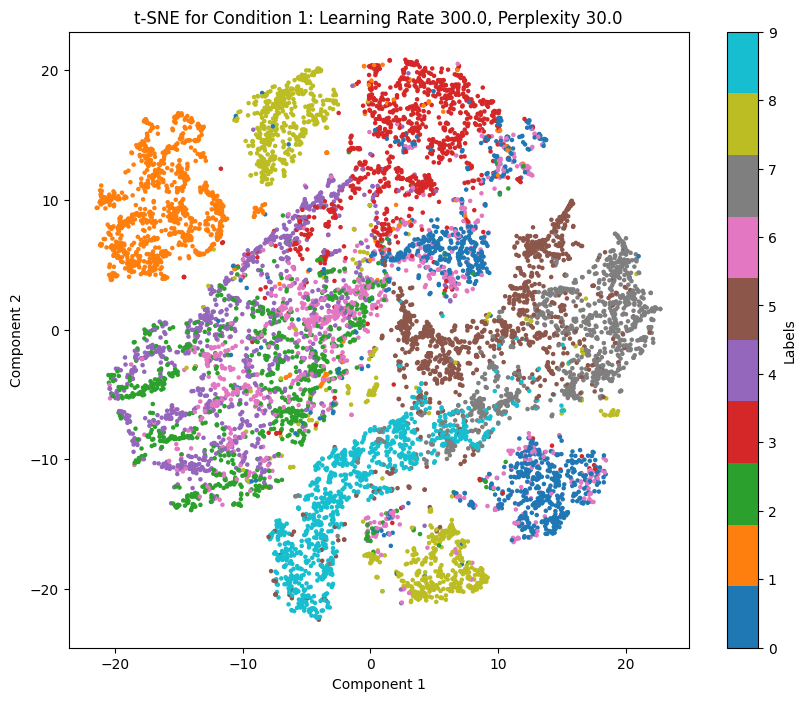

Running t-SNE for condition 2: {'learning_rate': 500.0, 'perplexity': 50.0, 'max_iters': 1000}


t-SNE optimization:  10%|█         | 100/1000 [00:44<06:38,  2.26it/s]

Iteration 100: KL Divergence = 19.420873641967773


t-SNE optimization:  20%|██        | 200/1000 [01:28<05:51,  2.27it/s]

Iteration 200: KL Divergence = 2.3717544078826904


t-SNE optimization:  30%|███       | 300/1000 [02:12<05:13,  2.23it/s]

Iteration 300: KL Divergence = 2.1395792961120605


t-SNE optimization:  40%|████      | 400/1000 [02:56<04:25,  2.26it/s]

Iteration 400: KL Divergence = 2.019044876098633


t-SNE optimization:  50%|█████     | 500/1000 [03:41<03:42,  2.25it/s]

Iteration 500: KL Divergence = 1.9403109550476074


t-SNE optimization:  60%|██████    | 600/1000 [04:25<03:00,  2.22it/s]

Iteration 600: KL Divergence = 1.883101224899292


t-SNE optimization:  70%|███████   | 700/1000 [05:09<02:14,  2.23it/s]

Iteration 700: KL Divergence = 1.838787317276001


t-SNE optimization:  80%|████████  | 800/1000 [05:54<01:28,  2.26it/s]

Iteration 800: KL Divergence = 1.8030786514282227


t-SNE optimization:  90%|█████████ | 900/1000 [06:38<00:44,  2.25it/s]

Iteration 900: KL Divergence = 1.7735083103179932


t-SNE optimization: 100%|██████████| 1000/1000 [07:22<00:00,  2.26it/s]

Iteration 1000: KL Divergence = 1.7484419345855713
Hyperparameters: {'learning_rate': 500.0, 'perplexity': 50.0, 'max_iters': 1000}, Sum of Centroid Distances (D): 22405.88513553096
Hyperparameters: {'learning_rate': 500.0, 'perplexity': 50.0, 'max_iters': 1000}, , Objective Function (J): 842244.08203125


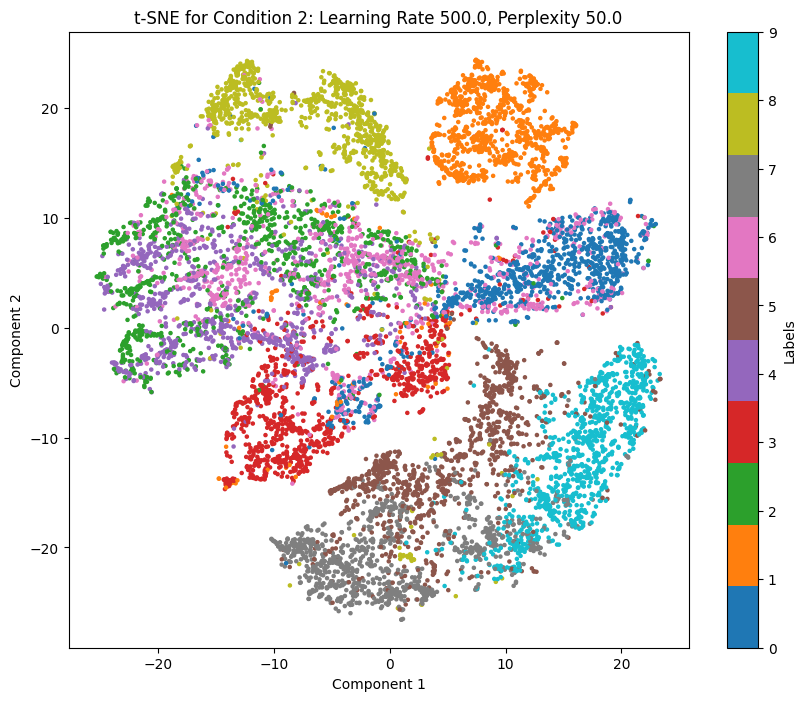

Running t-SNE for condition 3: {'learning_rate': 400.0, 'perplexity': 40.0, 'max_iters': 1000}


t-SNE optimization:  10%|█         | 100/1000 [00:44<06:43,  2.23it/s]

Iteration 100: KL Divergence = 20.745738983154297


t-SNE optimization:  20%|██        | 200/1000 [01:29<05:54,  2.26it/s]

Iteration 200: KL Divergence = 2.6412785053253174


t-SNE optimization:  30%|███       | 300/1000 [02:14<05:12,  2.24it/s]

Iteration 300: KL Divergence = 2.3797004222869873


t-SNE optimization:  40%|████      | 400/1000 [02:58<04:25,  2.26it/s]

Iteration 400: KL Divergence = 2.2422847747802734


t-SNE optimization:  50%|█████     | 500/1000 [03:42<03:40,  2.27it/s]

Iteration 500: KL Divergence = 2.152313709259033


t-SNE optimization:  60%|██████    | 600/1000 [04:26<02:56,  2.26it/s]

Iteration 600: KL Divergence = 2.086719036102295


t-SNE optimization:  70%|███████   | 700/1000 [05:11<02:13,  2.25it/s]

Iteration 700: KL Divergence = 2.03584623336792


t-SNE optimization:  80%|████████  | 800/1000 [05:55<01:30,  2.21it/s]

Iteration 800: KL Divergence = 1.994701862335205


t-SNE optimization:  90%|█████████ | 900/1000 [06:42<00:46,  2.16it/s]

Iteration 900: KL Divergence = 1.9604724645614624


t-SNE optimization: 100%|██████████| 1000/1000 [07:27<00:00,  2.24it/s]

Iteration 1000: KL Divergence = 1.931251049041748
Hyperparameters: {'learning_rate': 400.0, 'perplexity': 40.0, 'max_iters': 1000}, Sum of Centroid Distances (D): 16917.670179473986
Hyperparameters: {'learning_rate': 400.0, 'perplexity': 40.0, 'max_iters': 1000}, , Objective Function (J): 1018116.77734375


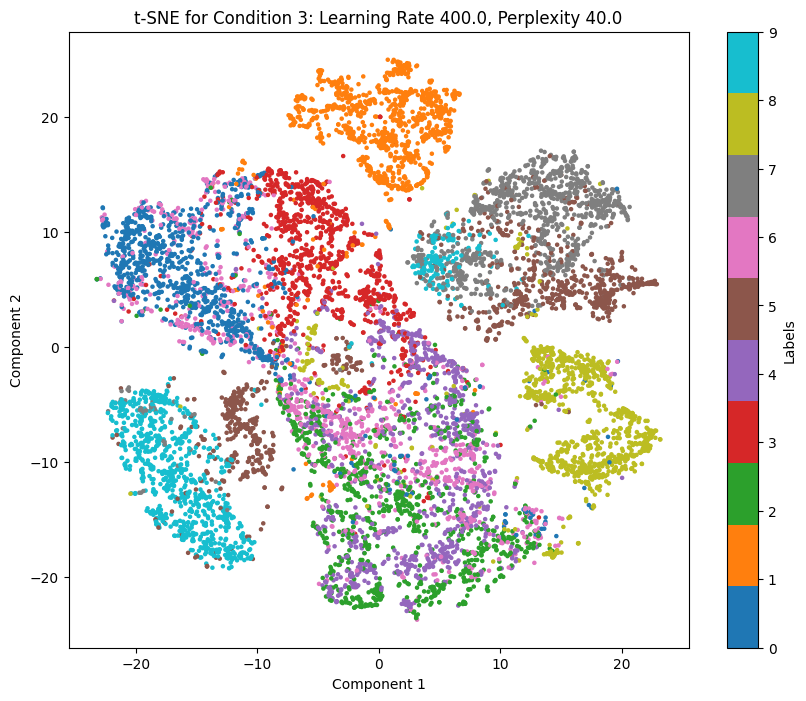

Running t-SNE for condition 4: {'learning_rate': 600.0, 'perplexity': 20.0, 'max_iters': 1000}


t-SNE optimization:  10%|█         | 100/1000 [00:44<06:37,  2.26it/s]

Iteration 100: KL Divergence = 21.615360260009766


t-SNE optimization:  20%|██        | 200/1000 [01:29<05:53,  2.26it/s]

Iteration 200: KL Divergence = 2.9192700386047363


t-SNE optimization:  30%|███       | 300/1000 [02:14<05:15,  2.22it/s]

Iteration 300: KL Divergence = 2.641167163848877


t-SNE optimization:  40%|████      | 400/1000 [02:58<04:25,  2.26it/s]

Iteration 400: KL Divergence = 2.4904227256774902


t-SNE optimization:  50%|█████     | 500/1000 [03:43<03:47,  2.20it/s]

Iteration 500: KL Divergence = 2.389796018600464


t-SNE optimization:  60%|██████    | 600/1000 [04:28<02:56,  2.26it/s]

Iteration 600: KL Divergence = 2.3151955604553223


t-SNE optimization:  70%|███████   | 700/1000 [05:13<02:13,  2.25it/s]

Iteration 700: KL Divergence = 2.256680488586426


t-SNE optimization:  80%|████████  | 800/1000 [05:58<01:30,  2.22it/s]

Iteration 800: KL Divergence = 2.209054946899414


t-SNE optimization:  90%|█████████ | 900/1000 [06:42<00:44,  2.27it/s]

Iteration 900: KL Divergence = 2.1691386699676514


t-SNE optimization: 100%|██████████| 1000/1000 [07:27<00:00,  2.23it/s]

Iteration 1000: KL Divergence = 2.1349263191223145
Hyperparameters: {'learning_rate': 600.0, 'perplexity': 20.0, 'max_iters': 1000}, Sum of Centroid Distances (D): 30442.079974306194
Hyperparameters: {'learning_rate': 600.0, 'perplexity': 20.0, 'max_iters': 1000}, , Objective Function (J): 1492829.53125


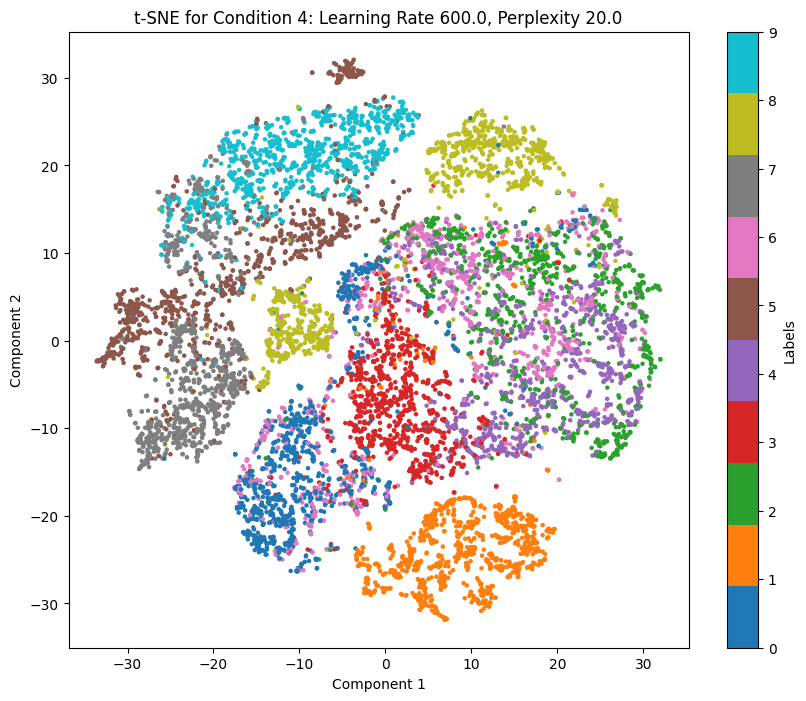

Running t-SNE for condition 5: {'learning_rate': 200.0, 'perplexity': 60.0, 'max_iters': 1000}


t-SNE optimization:  10%|█         | 100/1000 [00:45<06:43,  2.23it/s]

Iteration 100: KL Divergence = 22.862010955810547


t-SNE optimization:  20%|██        | 200/1000 [01:30<05:59,  2.22it/s]

Iteration 200: KL Divergence = 2.6635921001434326


t-SNE optimization:  30%|███       | 300/1000 [02:15<05:12,  2.24it/s]

Iteration 300: KL Divergence = 2.358449935913086


t-SNE optimization:  40%|████      | 400/1000 [03:00<04:33,  2.19it/s]

Iteration 400: KL Divergence = 2.2020983695983887


t-SNE optimization:  50%|█████     | 500/1000 [03:44<03:40,  2.27it/s]

Iteration 500: KL Divergence = 2.1012556552886963


t-SNE optimization:  60%|██████    | 600/1000 [04:28<02:56,  2.26it/s]

Iteration 600: KL Divergence = 2.0286855697631836


t-SNE optimization:  70%|███████   | 700/1000 [05:12<02:12,  2.26it/s]

Iteration 700: KL Divergence = 1.972826600074768


t-SNE optimization:  80%|████████  | 800/1000 [05:56<01:28,  2.25it/s]

Iteration 800: KL Divergence = 1.928067684173584


t-SNE optimization:  90%|█████████ | 900/1000 [06:40<00:44,  2.23it/s]

Iteration 900: KL Divergence = 1.8910056352615356


t-SNE optimization: 100%|██████████| 1000/1000 [07:25<00:00,  2.25it/s]

Iteration 1000: KL Divergence = 1.8595794439315796
Hyperparameters: {'learning_rate': 200.0, 'perplexity': 60.0, 'max_iters': 1000}, Sum of Centroid Distances (D): 10582.082787770018
Hyperparameters: {'learning_rate': 200.0, 'perplexity': 60.0, 'max_iters': 1000}, , Objective Function (J): 326831.576171875


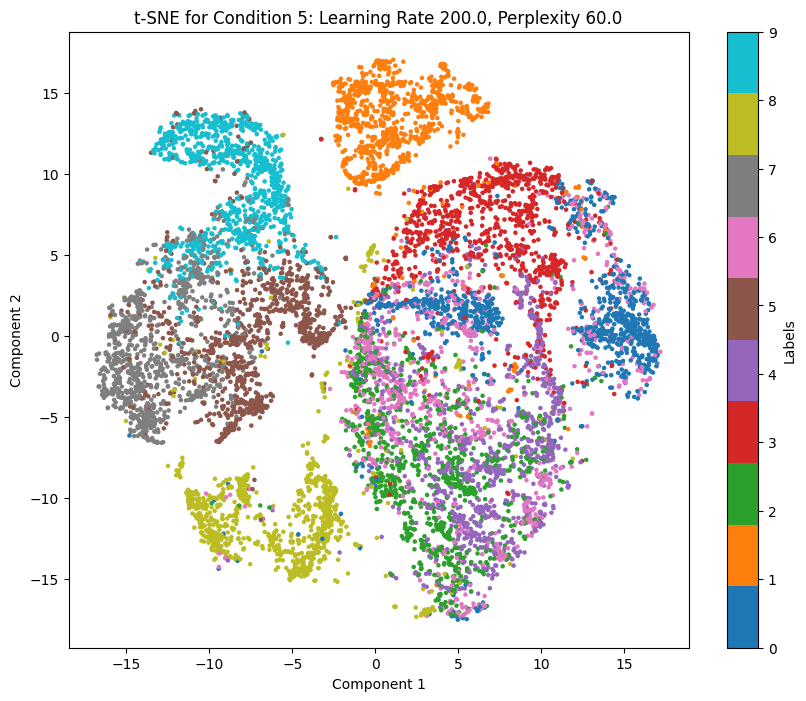

In [ ]:
# Centroid Calculation
def calculate_centroids(Y_2d, y_labels):
    centroids = []
    for label in range(10):  # Assuming 10 labels for Fashion MNIST
        indices = (y_labels == label).nonzero()
        centroid = Y_2d[indices].mean(axis=0)
        centroids.append(centroid)
    return np.array(centroids)

# Distance D Calculation
def calculate_D(centroids):
    D = 0.0
    n_centroids = len(centroids)
    for i in range(n_centroids):
        for j in range(i + 1, n_centroids):
            D += np.linalg.norm(centroids[i] - centroids[j]) ** 2
    return D

# Corrected Objective Function J in 2D space
def calculate_J(Y_2d, centroids, y_labels):
    J = 0.0
    for label in range(10):  # Assuming 10 labels
        indices = (y_labels == label).nonzero()[0]  # Get indices for the label
        label_centroid = centroids[label]
        J += np.sum(np.linalg.norm(Y_2d[indices] - label_centroid, axis=1) ** 2)
    return J

# Experimenting with 5 different hyperparameters and compute D and J
hyperparameter_conditions = [
    {'learning_rate': 300.0, 'perplexity': 30.0, 'max_iters': 1000},
    {'learning_rate': 500.0, 'perplexity': 50.0, 'max_iters': 1000},
    {'learning_rate': 400.0, 'perplexity': 40.0, 'max_iters': 1000},
    {'learning_rate': 600.0, 'perplexity': 20.0, 'max_iters': 1000},
    {'learning_rate': 200.0, 'perplexity': 60.0, 'max_iters': 1000}
]

results = []

for i, params in enumerate(hyperparameter_conditions):
    print(f"Running t-SNE for condition {i + 1}: {params}")
    Y_2d = run_tsne(X, n_components=2, **params)

    # Move the embeddings to CPU for centroid calculation
    Y_2d_cpu = Y_2d.cpu().detach().numpy()
    y_cpu = y.cpu().numpy()

    # Calculate centroids and D
    centroids = calculate_centroids(Y_2d_cpu, y_cpu)
    D = calculate_D(centroids)

    # Calculate objective function J using the reduced 2D embeddings
    J = calculate_J(Y_2d_cpu, centroids, y_cpu)

    results.append((params, D, J))
    print(f"Hyperparameters: {params}, Sum of Centroid Distances (D): {D}")
    print(f"Hyperparameters: {params}, , Objective Function (J): {J}")
    # Plot each result
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(Y_2d_cpu[:, 0], Y_2d_cpu[:, 1], c=y_cpu, cmap='tab10', s=5)
    plt.colorbar(scatter, label='Labels')
    plt.title(f"t-SNE for Condition {i + 1}: Learning Rate {params['learning_rate']}, Perplexity {params['perplexity']}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()


Best hyperparameters: {'learning_rate': 600.0, 'perplexity': 20.0, 'max_iters': 1000}
Best D (Centroid Distance): 30442.079974306194
Corresponding Objective Function J: 1492829.53125


t-SNE optimization:  10%|█         | 100/1000 [00:45<06:40,  2.25it/s]

Iteration 100: KL Divergence = 21.825679779052734


t-SNE optimization:  20%|██        | 200/1000 [01:30<06:01,  2.21it/s]

Iteration 200: KL Divergence = 2.9308645725250244


t-SNE optimization:  30%|███       | 300/1000 [02:14<05:10,  2.25it/s]

Iteration 300: KL Divergence = 2.6503164768218994


t-SNE optimization:  40%|████      | 400/1000 [02:59<04:28,  2.24it/s]

Iteration 400: KL Divergence = 2.498380184173584


t-SNE optimization:  50%|█████     | 500/1000 [03:43<03:41,  2.26it/s]

Iteration 500: KL Divergence = 2.3967747688293457


t-SNE optimization:  60%|██████    | 600/1000 [04:27<02:57,  2.25it/s]

Iteration 600: KL Divergence = 2.3216986656188965


t-SNE optimization:  70%|███████   | 700/1000 [05:12<02:14,  2.23it/s]

Iteration 700: KL Divergence = 2.262850761413574


t-SNE optimization:  80%|████████  | 800/1000 [05:57<01:32,  2.17it/s]

Iteration 800: KL Divergence = 2.2149133682250977


t-SNE optimization:  90%|█████████ | 900/1000 [06:41<00:44,  2.25it/s]

Iteration 900: KL Divergence = 2.1747093200683594


t-SNE optimization: 100%|██████████| 1000/1000 [07:26<00:00,  2.24it/s]

Iteration 1000: KL Divergence = 2.1402621269226074


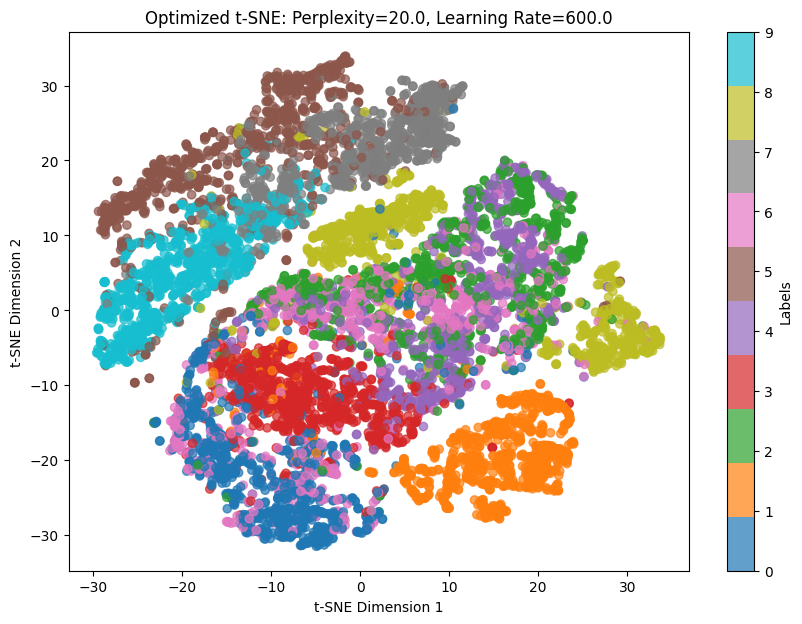

In [ ]:
# best result by maximizing the centroid distance (D)
best_result = max(results, key=lambda x: x[1])  # x[1] is the D value in results tuple

# Extracting best hyperparameters
best_params = best_result[0]
print(f"Best hyperparameters: {best_params}")
print(f"Best D (Centroid Distance): {best_result[1]}")
print(f"Corresponding Objective Function J: {best_result[2]}")
Y_best_exp = run_tsne(X, n_components=2, learning_rate=best_params['learning_rate'],
                     max_iters=best_params['max_iters'], perplexity=best_params['perplexity'])

# embeddings to CPU
Y_best = Y_best_exp.cpu().detach().numpy()
y_cpu = y.cpu().numpy()
plt.figure(figsize=(10, 7))
scatter = plt.scatter(Y_best[:, 0], Y_best[:, 1], c=y_cpu, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label="Labels")
plt.title(f"Optimized t-SNE: Perplexity={best_params['perplexity']}, Learning Rate={best_params['learning_rate']}")
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()